In [124]:
# Necessary imports
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import datetime
import scipy.stats as stats 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, LassoCV, Ridge, lars_path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

#%matplotlib inline
sns.set()

In [125]:
# Load data
df = pd.read_csv('outputversion.csv')
df.head()

,Unnamed: 0,Name,Price,Address,District,Completion_Year,Leasehold,Bedroom,Bathroom,Sqft,Sqm
0,0,Euhabitat,710000,210 Jalan Eunos,D14,2015,99 years,1,1,624,57.97
1,1,Marina One Residences,1580000,21 Marina Way,D1,2018,99 years,1,1,775,71.99
2,2,Vibes @ East Coast,630000,308 Telok Kurau Road,D15,2015,Freehold,1,1,409,37.99
3,3,Palm Gardens,915000,2B Hong San Walk,D23,2000,99 years,3,3,1216,112.97
4,4,Sims Urban Oasis,1080000,8 Sims Drive,D14,2020,99 years,2,1,667,61.96


In [126]:
df.sort_values(by= 'Price', ascending = False)

,Unnamed: 0,Name,Price,Address,District,Completion_Year,Leasehold,Bedroom,Bathroom,Sqft,Sqm
1170,1170,Skyline @ Orchard Boulevard,52217000,23 Angullia Park,D9,2015,Freehold,4,4,9494,882.02
578,578,Skyline @ Orchard Boulevard,49606150,23 Angullia Park,D9,2015,Freehold,4,5,9494,882.02
634,634,Nouvel 18,32600000,16 Anderson Road,D10,2014,Freehold,4,5,6125,569.03
632,632,Reignwood Hamilton Scotts,30000000,37 Scotts Road,D9,2012,Freehold,5,4,6975,647.99
100,100,Marina Bay Suites,28800000,3 Central Boulevard,D1,2013,99 years,5,7,8513,790.88
...,...,...,...,...,...,...,...,...,...,...,...
1133,1133,The Inflora,530000,67 Flora Drive,D17,2016,99 years,1,1,474,44.03
171,171,Parc Rosewood,530000,73 Rosewood Drive,D25,2014,99 years,1,1,431,40.04
1345,1345,The Hillford,521000,172 Jalan Jurong Kechil,D21,2017,60 years,1,1,398,36.97
1456,1456,Parc Rosewood,500000,77 Rosewood Drive,D25,2014,99 years,1,1,431,40.04


In [127]:
### CLEANING DATASET TO PREPARE FOR REGRESSION###


# We don't need Unnamed and Sqm
df.drop(columns =['Unnamed: 0','Sqm'], inplace = True)
#We remove the outliers
df = df.drop(1516)
df = df.drop(706)

#Check for empty spaces in Completion_Year Columns
df[df['Completion_Year'] == ' '].index
Empty_Completion_Year = df[df['Completion_Year'] == ' ' ].index
df.drop(Empty_Completion_Year , inplace=True)

# Next we check District for D0 since we initialize D0 to replace the missing districts and drop them
df[df['District'] == ' D0'].index
District_Zero = df[df['District'] == ' D0' ].index
df.drop(District_Zero , inplace=True)

#Write a code to organize the Districts into 3 Regions
#CCR - D9,D10,D11,D1,D2,D6
#RCR - 3,4,5,7,8,12,13,14,15,20
#Under OCR we have
#EPR -16, 17, 18
#NEPR - 19, 26, 28
#NPR - 24, 25, 27
#WPR - 21, 22, 23

df.loc[(df['District'] == ' D9') | (df['District'] == ' D10') | (df['District'] == ' D11')
       | (df['District'] == ' D1') | (df['District'] == ' D2') | (df['District'] == ' D6')
       , 'Region'] = 'CCR'

df.loc[(df['District'] == ' D3') | (df['District'] == ' D4') | (df['District'] == ' D5')
       | (df['District'] == ' D7') | (df['District'] == ' D8') | (df['District'] == ' D12')
       | (df['District'] == ' D13') | (df['District'] == ' D14') | (df['District'] == ' D15')
       | (df['District'] == ' D20'), 'Region'] = 'RCR'

df.loc[(df['District'] == ' D16') | (df['District'] == ' D17') | (df['District'] == ' D18')
       | (df['District'] == ' D19') | (df['District'] == ' D21') | (df['District'] == ' D22')
       | (df['District'] == ' D23') | (df['District'] == ' D24') | (df['District'] == ' D25')
       | (df['District'] == ' D26') | (df['District'] == ' D27') | (df['District'] == ' D28')
       , 'Region'] = 'OCR'


#Check NA Bedroom and drop it
df[df['Bedroom'] == 'Na'].index
NA_Bedroom = df[df['Bedroom'] == 'Na' ].index
df.drop(NA_Bedroom , inplace=True)

#We treat Studio as 1 Bedroom
df['Bedroom'] = df['Bedroom'].replace(['Studio'],'1')
#Convert Bedroom to int 
df["Bedroom"] = df["Bedroom"].astype(str).astype(int)

#Convert Completion Year to int so that we can find current age
df["Completion_Year"] = df["Completion_Year"].astype(str).astype(int)
df["Age"] = 2020 - df["Completion_Year"]

#We treat 100, 103 years as 99 years, 946,945,999 years as free hold
df['Leasehold'] = df['Leasehold'].replace([' 100 years'],' 99 years')
df['Leasehold'] = df['Leasehold'].replace([' 103 years'],' 99 years')
df['Leasehold'] = df['Leasehold'].replace([' 946 years'],' 999 years')
df['Leasehold'] = df['Leasehold'].replace([' 956 years'],' 999 years')
df['Leasehold'] = df['Leasehold'].replace([' 999 years'],' 999 years')

#Remove rows with 60 years lease
Lease_60 = df[df['Leasehold'] == ' 60 years' ].index
df.drop(Lease_60 , inplace=True)


df['Leasehold'] = df['Leasehold'].replace([' 99 years'],'99years')
df['Leasehold'] = df['Leasehold'].replace([' 999 years'],'999years')
df['Leasehold'] = df['Leasehold'].replace([' Freehold'],'Freehold')


# We use age to replace Completion_Years for regression.
df.drop(columns =['Completion_Year'], inplace = True)
#(TBC)We drop the name and address for simplicity sake
df.drop(columns =['Name', 'Address'], inplace = True)
df.drop(columns =['District'], inplace = True)

#Re-index the dataframe
df.reset_index().drop(columns =['index']) 

,Price,Leasehold,Bedroom,Bathroom,Sqft,Region,Age
0,710000,99years,1,1,624,RCR,5
1,1580000,99years,1,1,775,CCR,2
2,630000,Freehold,1,1,409,RCR,5
3,915000,99years,3,3,1216,OCR,20
4,1080000,99years,2,1,667,RCR,0
...,...,...,...,...,...,...,...
2141,900000,99years,2,2,957,RCR,15
2142,3160000,Freehold,3,2,1194,CCR,8
2143,5536000,Freehold,4,4,1744,CCR,2
2144,1150000,99years,2,1,657,RCR,-3


Text(0.5, 1.0, 'Price')

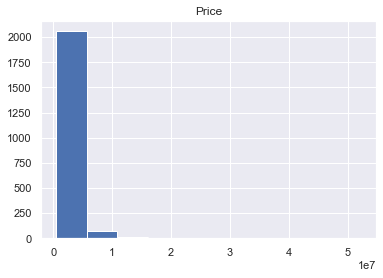

In [128]:
df.Price.hist();
plt.title("Price")

Text(0.5, 1.0, 'Log_Price')

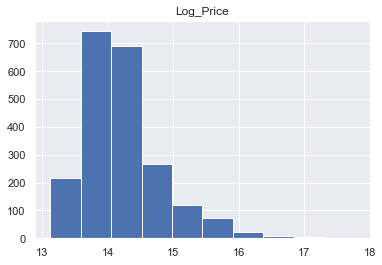

In [129]:
# take log of price as target and graph.  Call this log_price.
df['Log_Price']=np.log(df.Price)
# looks better
df.Log_Price.hist();
plt.title("Log_Price")

Text(0.5, 1.0, 'Correlation Matrix ~ Targets and Features')

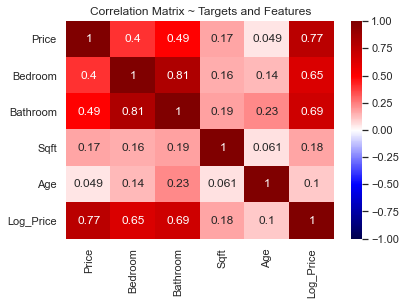

In [130]:
# example of a better corr matrix
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
plt.title("Correlation Matrix ~ Targets and Features")

In [131]:
#We see that bathroom has high correlation to bedroom and sqft, hence we drop the column
#We also drop price to clean the data
df = df.drop(['Bathroom', 'Price'], 1)
df

,Leasehold,Bedroom,Sqft,Region,Age,Log_Price
0,99years,1,624,RCR,5,13.473020
1,99years,1,775,CCR,2,14.272935
2,Freehold,1,409,RCR,5,13.353475
3,99years,3,1216,OCR,20,13.726679
4,99years,2,667,RCR,0,13.892472
...,...,...,...,...,...,...
2444,99years,2,957,RCR,15,13.710150
2446,Freehold,3,1194,CCR,8,14.966083
2447,Freehold,4,1744,CCR,2,15.526783
2448,99years,2,657,RCR,-3,13.955273


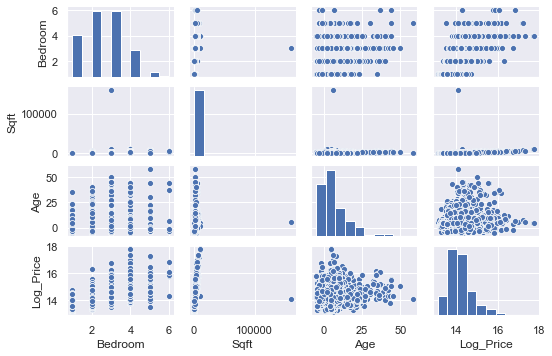

In [132]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df, height=1.2, aspect=1.5);

In [54]:
#Now we create dummies
df2 = pd.get_dummies(df, drop_first = True) #can just apply it to the whole df
df2.head(5)

,Bedroom,Sqft,Age,Log_Price,Leasehold_99years,Leasehold_Freehold,Region_OCR,Region_RCR
0,3,1636,45,14.316286,1,0,0,1
1,4,947,1,14.285514,1,0,0,1
2,1,689,13,13.997832,1,0,0,1
3,2,926,6,14.477167,0,1,0,0
4,3,893,3,14.137594,1,0,1,0


In [55]:
# slice data into features and target
X = df2.drop(columns=["Log_Price"]).astype(float)
y = df2.loc[:,"Log_Price"].astype(float)

In [102]:
# fit model with target as housing price index
housing_model = sm.OLS(y, X, data=df2,)

results = housing_model.fit()

# summarize our model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Log_Price   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          1.031e+04
Date:                Tue, 22 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:23:30   Log-Likelihood:                         -3025.6
No. Observations:                1437   AIC:                                      6065.
Df Residuals:                    1430   BIC:                                      6102.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Bedroom                0.7701      0.070     11.053      0.000       0.633       0.907
Sqft                   0.0004      0.000      4.209      0.000       0.000       0.001
Age                    0.0159      0.006      2.673      0.008       0.004       0.028
Leasehold_99years     10.8018      0.173     62.358      0.000      10.462      11.142
Leasehold_Freehold    11.3197      0.162     69.694      0.000      11.001      11.638
Region_OCR             0.8426      0.152      5.536      0.000       0.544       1.141
Region_RCR             1.1428      0.140      8.142      0.000       0.867       1.418
==============================================================================
Omnibus:                     1234.339   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28137.628
Skew:                           4.063   Prob(JB):                         0.00
Kurtosis:                      23.098   Cond. No.                     6.79e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [112]:
# Define the model
lm1 = smf.ols('Log_Price ~ Bedroom + Sqft + Age + Region_OCR + Region_RCR', data=df2)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1382.
Date:                Tue, 22 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:46:08   Log-Likelihood:                -63.334
No. Observations:                1437   AIC:                             138.7
Df Residuals:                    1431   BIC:                             170.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8499      0.022    634.812      0.000      13.807      13.893
Bedroom        0.1725      0.009     18.973      0.000       0.155       0.190
Sqft           0.0004   1.28e-05     32.428      0.000       0.000       0.000
Age           -0.0097      0.001    -12.755      0.000      -0.011      -0.008
Region_OCR    -0.7164      0.018    -39.163      0.000      -0.752      -0.680
Region_RCR    -0.4113      0.018    -22.600      0.000      -0.447      -0.376
==============================================================================
Omnibus:                       80.460   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.471
Skew:                           0.228   Prob(JB):                     3.68e-53
Kurtosis:                       4.956   Cond. No.                     5.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


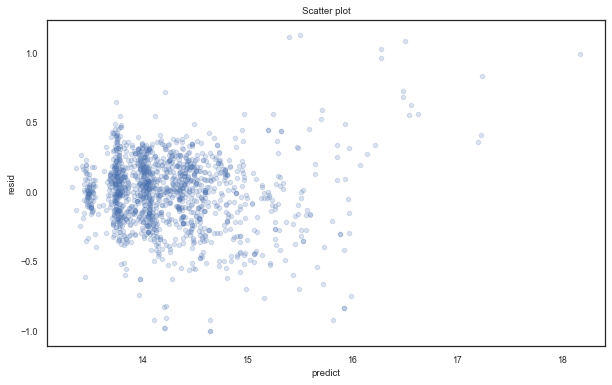

In [92]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis
df2a = df2.copy()
df2a['predict']=fit1.predict(X)
df2a['resid']=df2a.predict - df2a.Log_Price
with sns.axes_style('white'):
    plot=df2a.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))
    plt.title("Scatter plot")

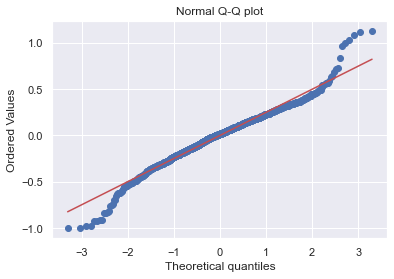

In [58]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(df2a['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [59]:
# Now we do validation and also Cross Validation
df3 = df2

X, y = df3.drop('Log_Price',axis=1), df3['Log_Price']

# hold out 20% of the data for final testing
X_train_val , X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [60]:
# hold out another 20% of the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=3)

In [61]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# X_train_val_scaled = scaler.fit_transform(X_train_val.values)
# X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=0.01)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

# X_train_val_poly = poly.fit_transform(X_train_val.values)
# X_test_poly = poly.transform(X_test.values)


lm_poly = LinearRegression()

In [62]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.823
Ridge Regression val R^2: 0.823
Degree 2 polynomial regression val R^2: 0.882


In [63]:
#Since poly regression gives the best R^2 for train set, we just poly regression to get the R^2 on the test dataset
# and also the coefficients
X_poly = poly.fit_transform(X_train.values)
lm_poly.fit(X_poly,y_train)
print(f'Degree 2 polynomial regression test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

Degree 2 polynomial regression test R^2: 0.868


In [64]:
#Next we get the mean absolute error
#Co-eff from poly regression
from sklearn import metrics

y_pred = lm_poly.predict(X_test_poly)
print(f'Degree 2 polynomial regression test mean absolute error: {metrics.mean_absolute_error(y_test, y_pred):.3f}')


Degree 2 polynomial regression test mean absolute error: 0.173


In [65]:
#now we get adjusted R2
R2 = lm_poly.score(X_test_poly, y_test)
print(1-(1-R2)*((len(X_test_poly)-1)/(len(X_test_poly)-len(X_test_poly[0])-1)))

0.8489935986016373


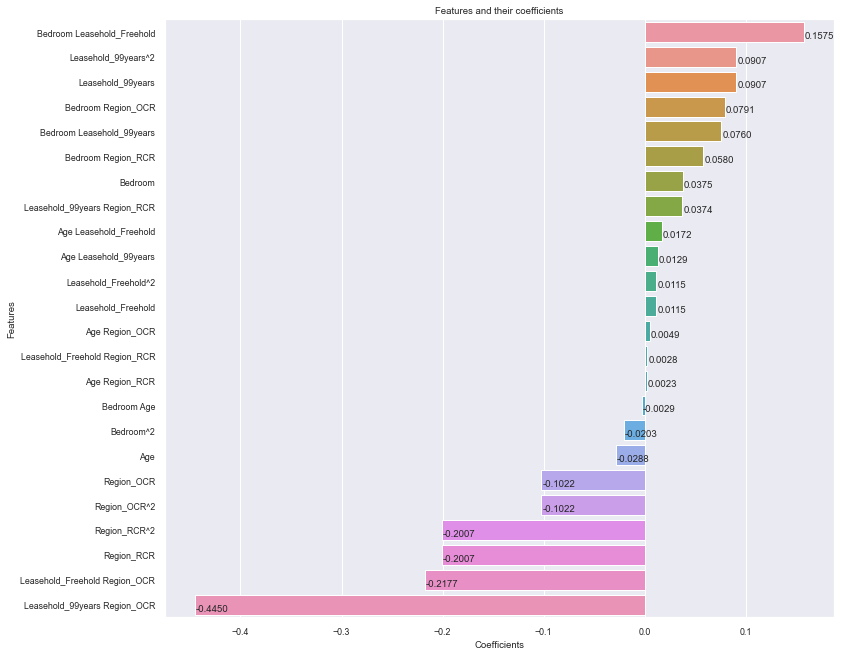

In [69]:
#Getting the coefficients for polynomial regression
poly = PolynomialFeatures(degree=2).fit(X)

#Now let's make it more presentable in Pandas DataFrame and also in standard form for numbers
df_lm_poly_coefficients = pd.DataFrame(list(zip(poly.get_feature_names(X.columns), lm_poly.coef_)))
df_lm_poly_coefficients.rename(columns={0:'Features', 1: 'Coefficients'}, inplace=True)

df_lm_poly_coefficients = df_lm_poly_coefficients.iloc[1:]
df_lm_poly_coefficients = df_lm_poly_coefficients.sort_values(by ='Coefficients', ascending = False)

#only retain the important ones.
df_lm_poly_coefficients_final = df_lm_poly_coefficients[(df_lm_poly_coefficients['Coefficients'] > 0.002) | 
                                                  (df_lm_poly_coefficients['Coefficients'] < -0.002)] 

plt.figure(figsize=(12,11))
sns.set_style('whitegrid')
sns.set(font_scale=0.8)

ax = sns.barplot(x = 'Coefficients',y='Features', data = df_lm_poly_coefficients_final)
ax.set_title("Features and their coefficients")

for p in ax.patches:
    ax.annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.8), xytext=(1, 4), textcoords='offset pixels')
plt.show()

In [70]:
test_set_pred = lm_poly.predict(X_test_poly)

Text(0.5, 1.0, 'Regression plot')

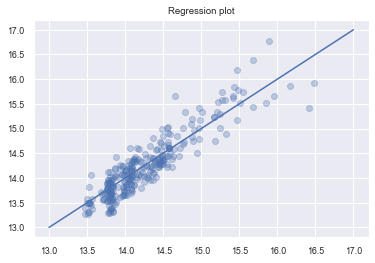

In [91]:
plt.scatter(test_set_pred, y_test, alpha=.3)
plt.plot(np.linspace(13,17,10), np.linspace(13,17,10))
plt.title("Regression plot")


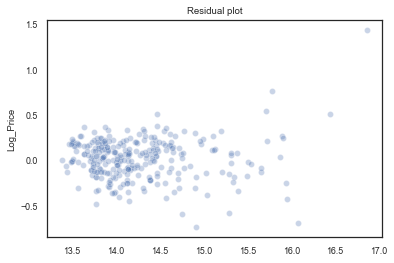

In [90]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis

polyfit = lm_poly.fit(X_train_poly, y_train)
y_pred_poly = polyfit.predict(X_test_poly)
resid_poly = y_pred_poly - y_test
with sns.axes_style('white'):
    sns.scatterplot(x = y_pred_poly, y = resid_poly, alpha = 0.3)
    plt.title("Residual plot")


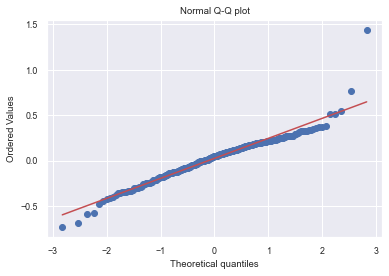

In [73]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(resid_poly, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Cross Validation with Scikit-learn

In [74]:
from sklearn.model_selection import cross_val_score

lm = LinearRegression() 

X_scaled = scaler.fit_transform(X.values)
lm_reg = Ridge(alpha=1)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
lm_poly = LinearRegression()


In [75]:
#Cross validation via the KFold method
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state = 10000)

simple_mean = np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2'))
simple_std = np.std(cross_val_score(lm, X, y, cv=kf, scoring='r2'))

ridge_mean = np.mean(cross_val_score(lm_reg, X_scaled, y, cv=kf, scoring='r2'))
ridge_std = np.std(cross_val_score(lm_reg, X_scaled, y, cv=kf, scoring='r2')) 

poly_mean = np.mean(cross_val_score(lm_poly, X_poly, y, cv=kf, scoring='r2'))
poly_std = np.std(cross_val_score(lm_poly, X_poly, y, cv=kf, scoring='r2'))

print(f'Simple mean cv r^2: {simple_mean:.3f} +- {simple_std:.3f}')
print(f'Ridge mean cv r^2: {ridge_mean:.3f} +- {ridge_std:.3f}')
print(f'Simple mean cv r^2: {poly_mean:.3f} +- {poly_std:.3f}')

Simple mean cv r^2: 0.825 +- 0.022
Ridge mean cv r^2: 0.825 +- 0.021
Simple mean cv r^2: 0.871 +- 0.019


In [76]:
#Now we get the adjusted R2

R2_linear = simple_mean.item()
R2_reg = ridge_mean.item()
R2_poly = poly_mean.item()

print(1-(1-R2_linear)*((len(X)-1)/(len(X)-X.shape[1]-1)))
print(1-(1-R2_reg)*((len(X)-1)/(len(X_scaled)-X_scaled.shape[1]-1)))
print(1-(1-R2_poly)*((len(X_poly)-1)/(len(X_poly)-X_poly.shape[1]-1)))

0.8238405728236047
0.8238588766591406
0.8677040583621826


In [77]:
#Next we find the mean absolute_error

kf = KFold(n_splits=5, shuffle=True, random_state = 10000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='neg_mean_absolute_error')))
print(np.mean(cross_val_score(lm_reg, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error')))
print(np.mean(cross_val_score(lm_poly, X_poly, y, cv=kf, scoring='neg_mean_absolute_error')))


-0.19266375511202888
-0.19267102303441447
-0.15999937211273757


### LASSO CV

In [78]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [79]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.01

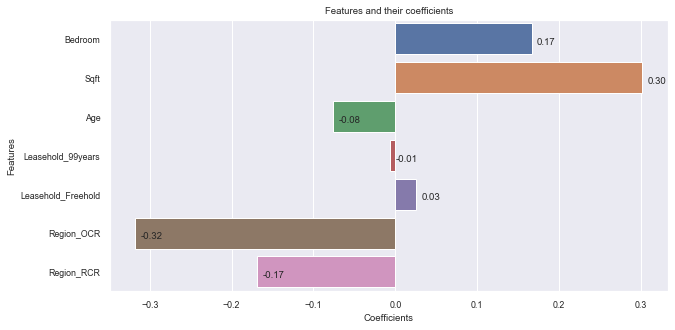

In [80]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

#Now let's make it more presentable in Pandas DataFrame and also in standard form for numbers
df_lasso_model_coefficients = pd.DataFrame(list(zip(X_train.columns, lasso_model.coef_)))
df_lasso_model_coefficients.rename(columns={0:'Features', 1: 'Coefficients'}, inplace=True)

df_lasso_model_coefficients

plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.set(font_scale=0.8)

ax = sns.barplot(x = 'Coefficients',y='Features', data = df_lasso_model_coefficients)
ax.set_title("Features and their coefficients")

for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.8), xytext=(5, 10), textcoords='offset pixels')
plt.show()

In [81]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_test_scaled)

In [82]:
#Mean Absolute Error (MAE)
np.mean(np.abs(test_set_pred - y_test)) 

0.2074095635890989

In [83]:
r2_score(y_test, test_set_pred)

0.8254926192708248

In [84]:
print(1-(1-r2_score(y_test, test_set_pred))*((len(X_test_scaled)-1)/(len(X_test_scaled)-len(X_test_scaled[0])-1)))

0.8211299347525955


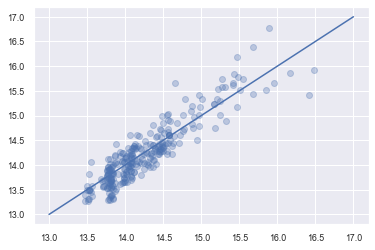

In [85]:
plt.scatter(test_set_pred, y_test, alpha=0.3)
plt.plot(np.linspace(13,17,10), np.linspace(13,17,10))

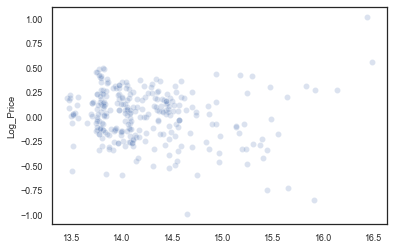

In [86]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis

X_train_val_scaled = scaler.fit_transform(X_train_val.values)
X_test_scaled = scaler.transform(X_test.values)
#  y_train_val, y_test

lassofit = lasso_model.fit(X_train_val_scaled, y_train_val)

y_pred_lasso = lassofit.predict(X_test_scaled)
resid_lasso = y_pred_lasso - y_test
with sns.axes_style('white'):
    sns.scatterplot(x=y_pred_lasso, y=resid_lasso, alpha=0.2)

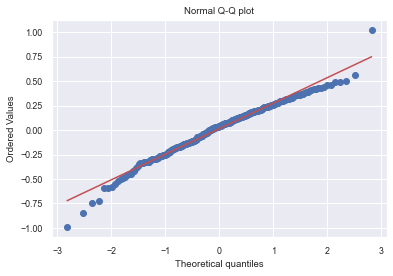

In [87]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(resid_lasso, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### LARS path

In [88]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train_scaled, y_train.values, method='lasso')

Computing regularization path using the LARS ...


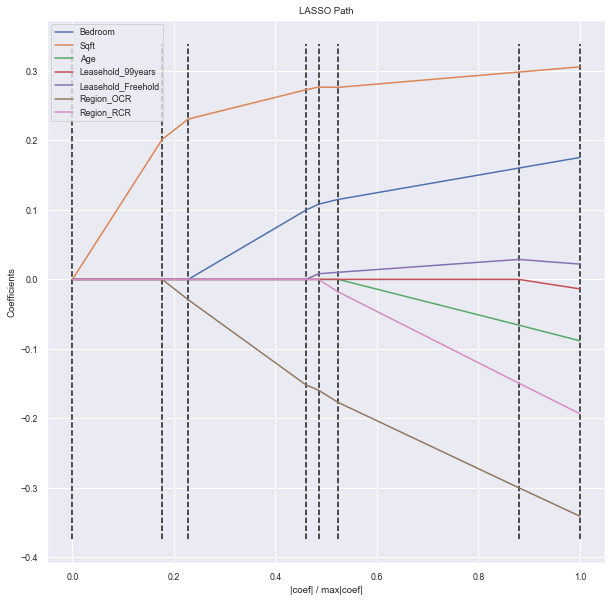

In [89]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()